In [1]:
# import libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# batch, classes, epochs
batch_size = 32
num_classes = 10
epochs = 10

In [40]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Pre-processing
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(-1,32, 32, 3)  # reshaping for convnet

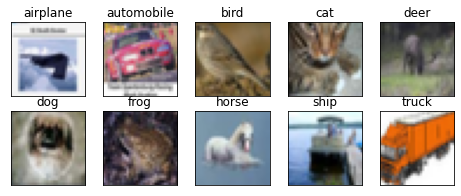

In [27]:
# plotting some random 10 images
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = (features_idx[img_num,::])
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [28]:
# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [29]:
# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [30]:
# summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)         

In [31]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# convert to float, normalise the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [32]:
# train 
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 2.1590 - accuracy: 0.2097 - val_loss: 2.0378 - val_accuracy: 0.2795
Epoch 2/10
1563/1563 [==============================] - 7s 4ms/step - loss: 2.0223 - accuracy: 0.2755 - val_loss: 1.9649 - val_accuracy: 0.3063
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9625 - accuracy: 0.2976 - val_loss: 1.8997 - val_accuracy: 0.3286
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9071 - accuracy: 0.3194 - val_loss: 1.8550 - val_accuracy: 0.3385
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.8625 - accuracy: 0.3338 - val_loss: 1.8158 - val_accuracy: 0.3523
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.8242 - accuracy: 0.3471 - val_loss: 1.7723 - val_accuracy: 0.3677
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.7966 - accuracy: 0.3586 - val_loss: 1.7349 - val_accuracy:

Result: After 50 epochs, the difference between training and validation accuracy is low but the training is slow as compared to the model with batch normalization.

In [33]:
# Install Keras Tuner
!pip install -q -U keras-tuner

In [34]:
import kerastuner as kt
import keras

In [35]:
def model_builder(hp):
  '''
  Builds the model and sets up the hyperparameters to tune.

  Args:
    hp - Keras tuner object

  Returns:
    model with hyperparameters to tune
  '''
  hp_filters=hp.Choice(
    'num_filters',
    values=[32, 64],
    default=64)
  
  hP_units=hp.Int(
      'units',
      min_value=32,
      max_value=512,
      step=32,
      default=128)
    
  '''hp_activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid'],
        default='relu')'''

  hp_dropouts=hp.Choice(
    'dropout',
    values=[0.25, 0.35, 0.5])

# Initialize the Sequential API and start stacking the layers
  model = Sequential()
  
  # Tune the number of units in the first Dense layer
  model.add(
    Conv2D(hp_filters, kernel_size=3,activation='relu',input_shape=x_train.shape[1:]))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(rate=hp_dropouts))
  model.add(Conv2D(hp_filters, 3, activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(rate=hp_dropouts))
  model.add(Flatten())
  model.add(Dense(units=hP_units, activation='relu'))
  model.add(Dropout(rate=hp_dropouts))
  model.add(Dense(num_classes, activation='softmax'))
  # Choose an optimal value between 32-512
  
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.001, 0.0001, 0.00001 or 0.000001
  hp_learning_rate = hp.Choice('learning_rate', values=[ 1e-3, 1e-4, 1e-5,1e-6])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

In [36]:
tuner = kt.Hyperband(
    model_builder,
    max_epochs=5,
    objective='val_accuracy',
    directory='hyperband',
    project_name='cifar10'
)

INFO:tensorflow:Reloading Oracle from existing project hyperband/cifar10/oracle.json


INFO:tensorflow:Reloading Oracle from existing project hyperband/cifar10/oracle.json


INFO:tensorflow:Reloading Tuner from hyperband/cifar10/tuner0.json


INFO:tensorflow:Reloading Tuner from hyperband/cifar10/tuner0.json


In [37]:
# Display hypertuning settings
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.35, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [38]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [41]:
# Perform hypertuning
tuner.search(x_train, y_train, epochs=5, validation_split=0.2, callbacks=[stop_early])


Trial 2 Complete [00h 00m 35s]
val_accuracy: 0.5281000137329102

Best val_accuracy So Far: 0.8999999761581421
Total elapsed time: 00h 01m 22s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [42]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

print('Optimum no of filter for conv layer is {}'.format(best_hps.get('num_filters')))
print('Optimum no of units in Dense layer is {}'.format(best_hps.get('units')))
print('Optimun Dropout value is {}'.format(best_hps.get('dropout')))
print('Optimum learning rate value is {}'.format(best_hps.get('learning_rate')))

Optimum no of filter for conv layer is 64
Optimum no of units in Dense layer is 128
Optimun Dropout value is 0.5
Optimum learning rate value is 0.0001


In [43]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [46]:
history = h_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 2.0327 - accuracy: 0.2381 - val_loss: 1.7827 - val_accuracy: 0.3864
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7237 - accuracy: 0.3662 - val_loss: 1.5580 - val_accuracy: 0.4537
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5918 - accuracy: 0.4195 - val_loss: 1.4704 - val_accuracy: 0.4859
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5163 - accuracy: 0.4476 - val_loss: 1.3874 - val_accuracy: 0.5158
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4595 - accuracy: 0.4722 - val_loss: 1.3345 - val_accuracy: 0.5345
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4169 - accuracy: 0.4887 - val_loss: 1.2942 - val_accuracy: 0.5528
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3805 - accuracy: 0.5062 - val_loss: 1.2672 - val_accuracy:

In [47]:
# evaluate the model on test data
h_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.1726 - accuracy: 0.5988


[1.1725748777389526, 0.598800003528595]